<div style="width:100%;text-align: top;"> <img align=middle src="https://mmo.aiircdn.com/141/5ed59862e602f.png" alt="Heat beating" style="height:400px;margin-top:1rem;"> </div>

## BUILDING ENERGY CONSUMPTION ANALYSIS

Climate change is a global challenge and carbon pollution knows no boundaries.<br>
In 2011, Seattle adopted the goal to become carbon neutral by 2050. The overall approach to carbon reductions in the buildings is to provide information, financial and other incentives, and technical assistance, while establishing strong standards for efficiency and emissions. <br>
As part of the City of Seattle, our team will focus on Green House Gas Emissions from non residential buildings.<br>
Our final objective is to predict CO2 emissions and the Total Energy Use for buildings that do not have yet any measurements.  <br>
To achieve this, we will use data measurements from 2 surveys carried out in 2015 & 2016. This notebook will deal with the data cleaning phase while we'll evaluate machine learning models later on.

In [1]:
#! usr/bin/env python 3
# coding: utf-8

# Importing librairies

import numpy as np                # numerical data processing
import pandas as pd               # numerical tables & time series
import scipy as sp                # numerical integration, interpolation, optimization, linear algebra, and statistics
import scipy.stats as st          # statistical functions
import seaborn as sns             # statistical data visualization
import matplotlib.pyplot as plt   # static, animated, and interactive visualizations in Python
import warnings
warnings.filterwarnings('ignore')

### CLEANING PHASE
__OVERVIEW OF THE DATASET__

In [2]:
# Transforming input files.csv to dataframes

df_energy_2015_init = pd.read_csv("2015-building-energy-benchmarking.csv")
df_energy_2016_init = pd.read_csv("2016-building-energy-benchmarking.csv")
df_energy_2015_init.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081


In [3]:
df_energy_2016_init.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86


__FEW FONCTIONS DEFINED TO HELP DESCRIBING THE CHARACTERISTICS OF THE INPUT FILES__

In [4]:
def duplicates (data):
    """Calculate the number of duplicates in dataframe data"""
    
    return len(data)-len(data.drop_duplicates())


def missing_cells (data):
    """Calculate the number of empty cells in dataframe data"""
    
    return data.isna().sum().sum()


def missing_cells_percent (data):
    """Calculate the percentage of empty cells in dataframe data""" 
    
    return missing_cells(data)/(data.size)*100
    

def filled_cells (data):
    """Calculate the number of existing values in dataframe data"""
    
    return data.notna().sum()  
    

def filled_cells_percent (data):
    """Calculate the percentage of existing values in dataframe data"""
    
    return filled_cells(data)/(len(data.index))*100


__CREATION OF A DATAFRAME SUMMARIZING KEY INFO FROM THE INPUT FILES__

In [5]:
# INITIALISE FILES_SPEC TO SERIES DICTIONARY

list_files = ['2015-building-energy-benchmarking.csv', '2016-building-energy-benchmarking.csv', ]
files_spec = {'Total rows' : pd.Series([len(df_energy_2015_init), len(df_energy_2016_init)],
                        index = list_files),
              'Total columns' : pd.Series([len(df_energy_2015_init.columns), len(df_energy_2016_init.columns)],
                        index = list_files),
              'Total duplicates' : pd.Series([duplicates(df_energy_2015_init), duplicates(df_energy_2016_init)],
                        index = list_files),
              'Total Missing cells ' : pd.Series([missing_cells(df_energy_2015_init), missing_cells(df_energy_2016_init) ],
                        index = list_files),
              'Missing cells (%)' : pd.Series([missing_cells_percent(df_energy_2015_init), missing_cells_percent(df_energy_2016_init)],
                        index = list_files)}

# Creates Dataframe df_files_spec

df_files_spec = pd.DataFrame(files_spec)
index = df_files_spec.index
index. name = "Input File Name"
round(df_files_spec, 2)


,Total rows,Total columns,Total duplicates,Total Missing cells,Missing cells (%)
Input File Name,,,,,
2015-building-energy-benchmarking.csv,3340,47,0,26512,16.89
2016-building-energy-benchmarking.csv,3376,46,0,19952,12.85


__BUILDING ONE DATAFRAME FROM THE 2 INPUT FILES__

Few choices have to be made following our strategy:<br>

1) Pick one data file between 2015 & 2016 - Training upcoming models on 1 year and testing it on the other year <br>
2) Merge both files in one single file, making a mean of numerical values between both files <br>
3) Keep data from both input files to generate a big dataframe and differenciate buildings on a YearDate for future encoding<br>

We went for the option number 3, trying to find differences between both files and reconstructing one single file with data from both files.

__Comparing the 2 input files__

In [6]:
# Features that are in 2015 but not in the 2016 file
[c for c in df_energy_2015_init if c not in df_energy_2016_init]

['Location',
 'OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

In [7]:
# Features that are in 2016 but not in the 2015 file
[d for d in df_energy_2016_init if d not in df_energy_2015_init]

['Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

__Focus on finding similarities between columns from both files__

In [8]:
# Split of the json "Location" column from 2015 into few columns

new = df_energy_2015_init["Location"].str.split(",|:", n = -1, expand = True)

# making separate column for each item 
df_energy_2015_init["Latitude"]= new[1]
df_energy_2015_init["Longitude"]= new[3]
df_energy_2015_init["Address"]= new[6]
df_energy_2015_init["City"]= new[8]
df_energy_2015_init["State"]= new[10]
df_energy_2015_init["ZipCode"]= new[12]
df_energy_2015 = df_energy_2015_init.drop(columns =["Location"])


# Clean the json style to make it similar to 2016 file
spec_chars = ['"',"'","{","}"]
for char in spec_chars:
        df_energy_2015 = df_energy_2015.replace(char,'', regex=True)

df_energy_2015.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,...,14.0,NaN,31.0,18081,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,...,14.0,NaN,31.0,18081,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101


__Existing data in 2015 that is not in 2016__

In [9]:
var_names = ['OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',  'Comment',
             '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts',
             'SPD Beats', 'Zip Codes']
df_rem_data = df_energy_2015[var_names]
percent_existing = df_rem_data.notnull().sum() * 100 / len(df_rem_data)
existing_data_df = pd.DataFrame({'Column label': df_rem_data.columns,
                                 'Existing data pct': percent_existing})
existing_data_df.reset_index(drop=True, inplace=True)
existing_data_df.sort_values('Existing data pct', ascending=False, inplace=True)
existing_data_df.index = np.arange(1, len(existing_data_df)+1)
existing_data_df['Existing data pct'] = existing_data_df['Existing data pct'].astype(float, errors = 'raise')
round(existing_data_df, 2)

,Column label,Existing data pct
1,Zip Codes,100.00
2,Seattle Police Department Micro Community Poli...,99.94
3,SPD Beats,99.94
4,OtherFuelUse(kBtu),99.70
5,GHGEmissions(MetricTonsCO2e),99.70
6,GHGEmissionsIntensity(kgCO2e/ft2),99.70
7,2010 Census Tracts,6.71
8,City Council Districts,6.38
9,Comment,0.39


__Few categories that are not particularly relevant to our study__

__2010 Census Tracts?__<br>
The "Census Tract" is an area roughly equivalent to a neighborhood established by the Bureau of Census for analyzing populations. They generally encompass a population between 2,500 to 8,000 people.

__Seattle Police Department Micro Community Policing Plan Areas?__<br>
The areas measured are concerns about crime and public safety and perceptions of police legitimacy, informal social control, social cohesion, fear of crime, social disorganization.

__What are Seattle Police Department (SPD) Beats?__<br>
Seattle is divided into five geographic areas. Within those areas are the 5 precincts or police stations: North, East, South, West and Southwest. Precinct boundaries were determined through consideration of neighborhood boundaries, geographic and other natural boundaries.

Each precinct contains smaller geographic areas called Sectors. There are 17 sectors total in the city.

Each of these Sectors are divided into between 3 smaller sections called Beats (i.e. Ocean sector has three beats O1, O2, O3) These are the areas that individual patrol officers are assigned responsibility for.

All features related to crime or safety in the different areas of the city will not give us any further information.

In [10]:
df_ener_15 = df_energy_2015.drop(['Zip Codes', 'Seattle Police Department Micro Community Policing Plan Areas',
                     'SPD Beats', '2010 Census Tracts', 'City Council Districts'], axis=1, inplace=True)
df_ener_15 = df_energy_2015.rename(columns={'Comment': 'Comments'})
df_energy_2016 = df_energy_2016_init[df_energy_2016_init['NumberofBuildings'].notnull()]
df_ener_15.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,...,No,NaN,Compliant,NaN,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,...,No,NaN,Compliant,NaN,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101


__'Comments' section does not have many entries but is helpful to understand building in construction between 2015 & 2016__

In [11]:
df_ener_15['Comments'].value_counts()

Construction completed in mid 2015. The building was unoccupied for most of 2015.                                                                                                                                                                                  1
Part of McKinstrys campus, the office space for this building sites on the 3rd floor above a 2-story parking garage and is served by rooftop package units for both heating and cooling. Learn more at www.mckinstryinnovationcenter.com.                          1
Part of McKinstrys campus, property includes a warehouse, a local pipe supplier, and a local insulation contractor.  Learn more at www.mckinstry.com.                                                                                                              1
Under construction starting 09/2014 (old building demolished) and ending 9/2017. New Buildings (two) re-open 9/2017. Year built changed from 1953 to 2017.                                                               

Most of these comments indicate new construction over the period 2015-2016 so we decide not to take into account these buildings.

In [12]:
ener2015 = df_ener_15[~df_ener_15['Comments'].notna()]
ener2015_bis = ener2015.drop(columns=['Comments'])


__Comparison of GHG Emissions to compare units__<br>Greenhouse gases are measured in 'carbon dioxide-equivalents' (CO2e). Data_energy_2015 have units in metrics tones CO2e while Data_energy_2016 do not have any units.
Plotting them side by side, both columns relate to each other in terms of order of magnitude so the 2016 data should be in metrics tones CO2e too.

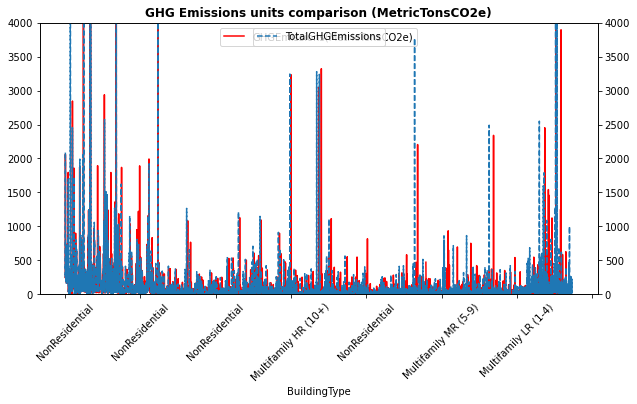

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()

ener2015_bis.plot(x="BuildingType", y=["GHGEmissions(MetricTonsCO2e)"], color="red", ax=ax)
df_energy_2016.plot(x="BuildingType", y=["TotalGHGEmissions"], ax=ax2, ls="--")
plt.title('GHG Emissions units comparison (MetricTonsCO2e)', fontsize = 12, weight = 'bold')
ax.set_ylim([0,4000])
ax2.set_ylim([0,4000])
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

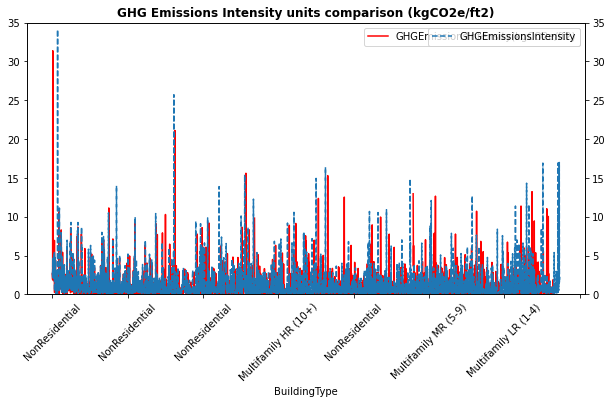

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
ener2015.plot(x="BuildingType", y=["GHGEmissionsIntensity(kgCO2e/ft2)"], color="red", ax=ax)
df_energy_2016.plot(x="BuildingType", y=["GHGEmissionsIntensity"], ax=ax2, ls="--")
plt.title('GHG Emissions Intensity units comparison (kgCO2e/ft2)', fontsize = 12, weight = 'bold')
ax.set_ylim(0,35)
ax2.set_ylim(0,35)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

Correlations between GHG Emissions & GHG Emissions Intensity can be seen of the plots above i.e. both input files have these features with the same units. They represent the same thing and can be called identically in both files.

In [15]:
ener2016 = df_energy_2016.rename(columns={'GHGEmissionsIntensity': 'GHGEmissionsIntensity(kgCO2e/ft2)', 'TotalGHGEmissions': 'GHGEmissions(MetricTonsCO2e)'})

We can now blend both dataframes together to get one single dataframe with both years of data.

__Concatenate both dataframes__

In [16]:
# An intermediate cleaning phase to transform all strings in small letters with the first letter
# of each word in capital to make both files identical in wording

data_both = pd.concat([ener2015, ener2016], axis = 0).sort_values(["OSEBuildingID", "DataYear"])
data_both['PropertyName'] = data_both['PropertyName'].str.title()
data_both['Neighborhood'] = data_both['Neighborhood'].str.title()
data_both['City'] = data_both['City'].str.title()
data_both['Address'] = data_both['Address'].str.title()
data_both.ZipCode = data_both.ZipCode.astype(float, errors = 'raise')
data_both.ZipCode = data_both.ZipCode.apply(lambda x: '{:.0f}'.format(x))
data_both.to_csv('databoth.csv')

# Dataframe containing both 2015 & 2016 info
data_both

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,Mayflower Park Hotel,659000030,7,Downtown,1927,1.0,...,No,NaN,Compliant,NaN,47.61219025,-122.33799744,405 Olive Way,Seattle,WA,98101
0,1,2016,NonResidential,Hotel,Mayflower Park Hotel,0659000030,7,Downtown,1927,1.0,...,False,NaN,Compliant,NaN,47.6122,-122.33799,405 Olive Way,Seattle,WA,98101
1,2,2015,NonResidential,Hotel,Paramount Hotel,659000220,7,Downtown,1996,1.0,...,No,NaN,Compliant,NaN,47.61310583,-122.33335756,724 Pine St,Seattle,WA,98101
1,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,Downtown,1996,1.0,...,False,NaN,Compliant,NaN,47.61317,-122.33393,724 Pine Street,Seattle,WA,98101
2,3,2015,NonResidential,Hotel,Westin Hotel,659000475,7,Downtown,1969,1.0,...,Yes,NaN,Compliant,NaN,47.61334897,-122.33769944,1900 5Th Ave,Seattle,WA,98101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture Building,1624049080,2,Greater Duwamish,1990,1.0,...,True,NaN,Error - Correct Default Data,NaN,47.56722,-122.31154,1600 S Dakota St,Seattle,WA,nan
3372,50223,2016,Nonresidential COS,Other,International District/Chinatown Cc,3558300000,2,Downtown,2004,1.0,...,False,NaN,Compliant,NaN,47.59625,-122.32283,719 8Th Ave S,Seattle,WA,nan
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1794501150,7,Magnolia / Queen Anne,1974,1.0,...,False,NaN,Compliant,NaN,47.63644,-122.35784,1920 1St Ave W,Seattle,WA,nan
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,7883603155,1,Greater Duwamish,1989,1.0,...,False,NaN,Compliant,NaN,47.52832,-122.32431,8319 8Th Ave S,Seattle,WA,nan


__Filling Rate for this new Dataframe__

In [17]:
percent_existing1 = data_both.notnull().sum() * 100 / len(data_both)
existing_data_df1 = pd.DataFrame({'Column label': data_both.columns,
                                 'Existing data pct': percent_existing1})
existing_data_df1.reset_index(drop=True, inplace=True)
existing_data_df1.sort_values('Existing data pct', ascending=False, inplace=True)
existing_data_df1.index = np.arange(1, len(existing_data_df1)+1)
existing_data_df1['Existing data pct'] = existing_data_df1['Existing data pct'].astype(float, errors = 'raise')
round(existing_data_df1, 2)

,Column label,Existing data pct
1,OSEBuildingID,100.00
2,PropertyGFATotal,100.00
3,State,100.00
4,City,100.00
5,Address,100.00
6,Longitude,100.00
7,Latitude,100.00
8,ComplianceStatus,100.00
9,DataYear,100.00
10,PropertyGFABuilding(s),100.00


__Weather Normalized Energy WNE__<br>
https://www.energystar.gov/sites/default/files/tools/Climate_and_Weather_2020_508.pdf<br>
Weather normalized energy is the energy a building would have used
under average conditions (also referred to as climate normals). The weather in a given year may be much
hotter or colder than a building’s normal climate; weather normalized energy accounts for this difference.
Note that the adjustment is for weather only, but not climate. That is, the metric evaluates a building
over time, but does not account for differences between a building and other locations that have different
average (normal) climates. Weather normalized energy is not available for new building design projects
because they have not yet experienced years with different weather.<br>
We decide to keep only non WNE features.

In [18]:
data_both.drop(['SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SourceEUIWN(kBtu/sf)' ], axis=1, inplace=True)
data_both.shape
# Reduction from 47 to 44 features


(6695, 44)

__Comparison between units in both 2015 & 2016__

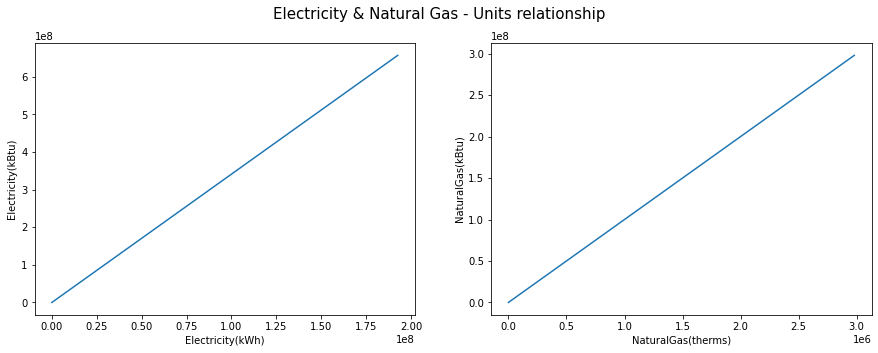

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15,5)) 
fig.suptitle(r"Electricity & Natural Gas - Units relationship", fontsize=15)

sns.lineplot(data=data_both, x='Electricity(kWh)', y = 'Electricity(kBtu)', ax=axes[0])
axes[0].set_xlabel("Electricity(kWh)")
axes[0].set_ylabel("Electricity(kBtu)")

sns.lineplot(data=data_both, x='NaturalGas(therms)', y = 'NaturalGas(kBtu)', ax=axes[1])
axes[1].set_xlabel("NaturalGas(therms)")
axes[1].set_ylabel("NaturalGas(kBtu)")
plt.show()

As seen on these 2 plots, Electricy in kWh and in kBtu as well as Natural Gas in therms and in kBtu follow a linear curve which means there is a perfect correlation between those parameters.<br>
Units conversion: 1 kWh = 3.412 kBtu and 1 Therm=~ 10kBtu. Input for these columns are identical but in different units so we'll keep the kBtu unit.

In [20]:
data_both.drop(['Electricity(kWh)', 'NaturalGas(therms)' ], axis=1, inplace=True)
data_both.shape

(6695, 42)

__Residential Buildings Only__<br>
Our team will look specifically to GHG Emissions from non residential buildings so all family households will be discarded in this study.

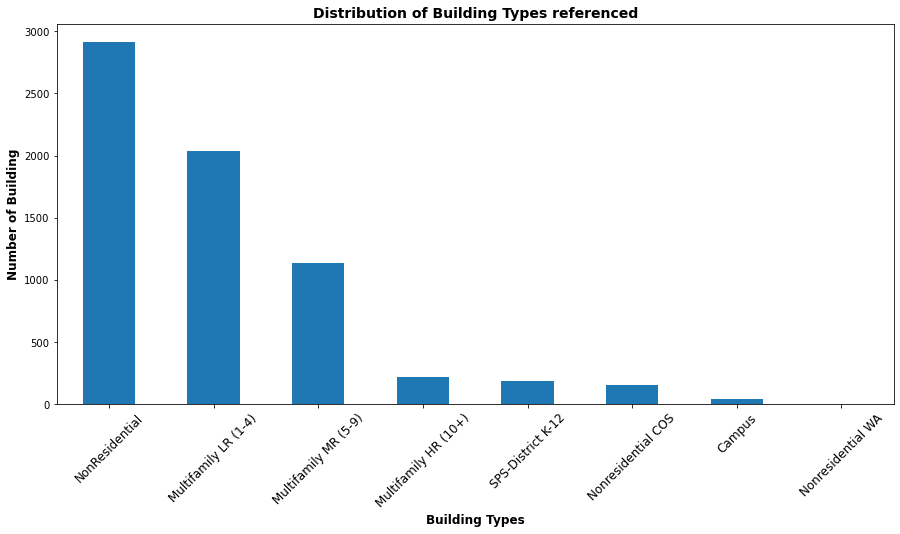

In [21]:
plt.rcParams["figure.figsize"] = (15,7)
res1 = data_both['BuildingType'].value_counts().plot(kind='bar')
plt.title('Distribution of Building Types referenced', fontsize = 14, weight = 'bold')
plt.xlabel ('Building Types', fontsize=12, weight = 'bold')
plt.ylabel ('Number of Building', fontsize=12, weight = 'bold')
res1.set_xticklabels (res1.get_xmajorticklabels(), rotation = 45, fontsize = 12, va = "top")
plt.show()

In [22]:
data_build = data_both[~data_both['BuildingType'].str.contains('Multifamily|Campus')]
data_build.shape

(3258, 42)

__Overview of the distribution of Primary Property Type contained in Building Types__

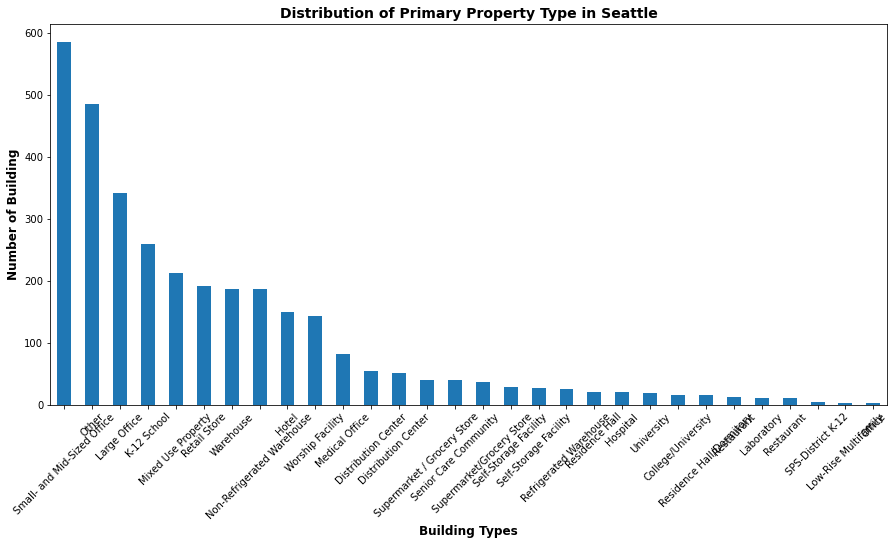

In [23]:
plt.rcParams["figure.figsize"] = (15,7)
res1 = data_build['PrimaryPropertyType'].value_counts().plot(kind='bar')
plt.title('Distribution of Primary Property Type in Seattle', fontsize = 14, weight = 'bold')
plt.xlabel ('Building Types', fontsize=12, weight = 'bold')
plt.ylabel ('Number of Building', fontsize=12, weight = 'bold')
res1.set_xticklabels (res1.get_xmajorticklabels(), rotation = 45, fontsize = 10, va = "top")
plt.show()

As seen on the graph above, offices (small to large) occupy most of the buildings.

__Focus on our targets Energy Use & Green House Gas Emissions__

As we focus on our targets: GHG Emissions & Site Energy Use, we remove all rows that do not contain this info.

In [24]:
data_sec = data_build[data_build['SiteEnergyUse(kBtu)'] != 0]
data_seca = data_sec[data_sec['GHGEmissions(MetricTonsCO2e)'] != 0]
data_seca = data_seca.dropna(subset = ['SiteEnergyUse(kBtu)'])
data_seca = data_seca.dropna(subset = ['GHGEmissions(MetricTonsCO2e)'])

__Few incorrect or negative data have been input__

In [25]:
numerical_columns = [c for c in data_seca.columns if data_seca[c].dtype.name != 'object']

data_seca[data_seca[numerical_columns] < 0].count() # to deal with int to str conversion problem

OSEBuildingID                        0
DataYear                             0
BuildingType                         0
PrimaryPropertyType                  0
PropertyName                         0
TaxParcelIdentificationNumber        0
CouncilDistrictCode                  0
Neighborhood                         0
YearBuilt                            0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFATotal                     0
PropertyGFAParking                   1
PropertyGFABuilding(s)               2
ListOfAllPropertyUseTypes            0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType         0
SecondLargestPropertyUseTypeGFA      0
ThirdLargestPropertyUseType          0
ThirdLargestPropertyUseTypeGFA       0
YearsENERGYSTARCertified             0
ENERGYSTARScore                      0
SiteEUI(kBtu/sf)                     0
SourceEUI(kBtu/sf)                   1
SiteEnergyUse(kBtu)      

In [26]:
indexNames = data_seca[(data_seca['Electricity(kBtu)'] < 0)].index

# Delete these row indexes from dataFrame
data_sec1 = data_seca.drop(indexNames)
indexNames2 = data_sec1[(data_sec1['PropertyGFAParking'] < 0)].index
data_sec2 = data_sec1.drop(indexNames2)
indexNames3 = data_sec2[(data_sec2['SourceEUI(kBtu/sf)'] < 0)].index
indexNames4 = data_sec2[(data_sec2['PropertyGFABuilding(s)'] < 0)].index
data_sec3 = data_sec2.drop(indexNames3)
data_sec4 = data_sec3.drop(indexNames4)
data_sec4[data_sec4[numerical_columns] < 0].count() # to deal with int to str conversion problem

OSEBuildingID                        0
DataYear                             0
BuildingType                         0
PrimaryPropertyType                  0
PropertyName                         0
TaxParcelIdentificationNumber        0
CouncilDistrictCode                  0
Neighborhood                         0
YearBuilt                            0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFATotal                     0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
ListOfAllPropertyUseTypes            0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType         0
SecondLargestPropertyUseTypeGFA      0
ThirdLargestPropertyUseType          0
ThirdLargestPropertyUseTypeGFA       0
YearsENERGYSTARCertified             0
ENERGYSTARScore                      0
SiteEUI(kBtu/sf)                     0
SourceEUI(kBtu/sf)                   0
SiteEnergyUse(kBtu)      

In [27]:
data_sec4.shape

(3230, 42)

Description of the different categories can be found here:
https://opendatanetwork.herokuapp.com/dataset/data.seattle.gov/h7rm-fz6m

__Compliance Status__

Implementation of energy codes is generally carried out by state and local agencies that are responsible for code compliance, enforcement, and training. These activities ensure that new construction meets the required level of efficiency.

In [28]:
data_sec4['ComplianceStatus'].value_counts()

Compliant                       3128
Error - Correct Default Data      87
Non-Compliant                     15
Name: ComplianceStatus, dtype: int64

In [29]:
# Reports with possible errors will require additional verification to be considered compliant.
# Work with compliant OSE Building ID only & we take the opportunity to drop other categories
# that are not critical for the analysis 

data_comp = data_sec4[data_sec4['ComplianceStatus'] == "Compliant"]
data_comp1 = data_comp.drop(['DefaultData', 'ComplianceStatus', 'CouncilDistrictCode', 'TaxParcelIdentificationNumber'], axis=1)
data_comp1['OtherFuelUse(kBtu)'] = data_comp1['OtherFuelUse(kBtu)'].fillna(0)
data_comp2 = data_comp1.drop(['Comments'], axis=1)


We fill few categories with the most frequent numbers when there is no data or 0 values.

In [30]:
data_comp2['NumberofBuildings'] = data_comp2.NumberofBuildings.mask(data_comp2.NumberofBuildings == 0,1)
data_comp2['NumberofFloors'] = data_comp2.NumberofFloors.mask(data_comp2.NumberofFloors == 0,1)
data_comp2['NumberofFloors'] = data_comp2['NumberofFloors'].fillna(1)
data_comp2.to_csv('datacomp.csv')
data_comp2.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,...,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2)
count,3128.000000,3128.000000,3128.000000,3128.000000,3128.00000,3.128000e+03,3128.000000,3.128000e+03,3.059000e+03,1622.000000,...,2095.000000,3128.000000,3128.000000,3.128000e+03,3.128000e+03,3.128000e+03,3.128000e+03,3.128000e+03,3128.000000,3128.000000
mean,15927.624680,2015.485934,1961.313619,1.038363,4.22890,1.113008e+05,13720.154092,9.758066e+04,9.010142e+04,35188.738777,...,63.879714,72.646515,178.545588,7.539494e+06,4.918133e+05,5.360123e+06,1.662621e+06,7.500842e+03,163.630627,1.478910
std,13319.378485,0.499882,32.754396,0.405982,6.71452,1.882730e+05,44057.609085,1.636532e+05,1.545127e+05,64495.650327,...,28.715195,73.022453,182.373434,1.842402e+07,5.157169e+06,1.296766e+07,5.422383e+06,2.024734e+05,559.031932,2.166351
min,1.000000,2015.000000,1900.000000,1.000000,1.00000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,...,1.000000,0.200000,0.000000,1.144100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.080000,0.000000
25%,588.000000,2015.000000,1929.000000,1.000000,1.00000,2.900000e+04,0.000000,2.812600e+04,2.505850e+04,5402.000000,...,45.000000,33.600000,77.775000,1.221320e+06,0.000000e+00,7.272658e+05,0.000000e+00,0.000000e+00,19.752500,0.270000
50%,21120.500000,2015.000000,1965.000000,1.000000,2.00000,4.817900e+04,0.000000,4.641250e+04,4.170400e+04,12062.500000,...,71.000000,52.400001,134.500000,2.549435e+06,0.000000e+00,1.642403e+06,4.584995e+05,0.000000e+00,48.600000,0.760000
75%,24538.000000,2016.000000,1988.000000,1.000000,4.00000,1.031415e+05,0.000000,9.355500e+04,8.849000e+04,30511.500000,...,88.000000,82.525000,207.399995,6.961197e+06,0.000000e+00,4.974732e+06,1.427482e+06,0.000000e+00,138.297500,1.790000
max,50226.000000,2016.000000,2015.000000,9.000000,99.00000,1.952220e+06,512608.000000,1.765970e+06,1.680937e+06,686750.000000,...,100.000000,834.400024,2620.000000,2.958126e+08,1.349435e+08,2.847263e+08,1.381912e+08,8.269669e+06,12307.160000,31.380000


We then regroup few sub-categories that represent more or less the same thing.

In [31]:
import re
regex = re.compile(r'[\n\r\t]')
data_comp2['PrimaryPropertyType'] = [regex.sub("", item) for index, item in data_comp2.PrimaryPropertyType.iteritems()]
data_comp2['PrimaryPropertyType'] = data_comp2['PrimaryPropertyType'].replace({'Supermarket / Grocery Store': 'Supermarket/Grocery Store',
                                        'College/University': 'University', 'Residence Hall/Dormitory': 'Residence Hall' })
data_comp2['LargestPropertyUseType'].value_counts()

Office                                                  952
Non-Refrigerated Warehouse                              389
Retail Store                                            187
Other                                                   183
K-12 School                                             171
Hotel                                                   143
Worship Facility                                        139
Distribution Center                                     106
Medical Office                                           84
Supermarket/Grocery Store                                77
Self-Storage Facility                                    54
Parking                                                  51
Other - Recreation                                       51
Other - Entertainment/Public Assembly                    41
Senior Care Community                                    39
Residence Hall/Dormitory                                 38
College/University                      

__FEATURE ENGINEERING__

We first create a new feature that will replace the year the buildings were built by a more quantitative feature: their age.

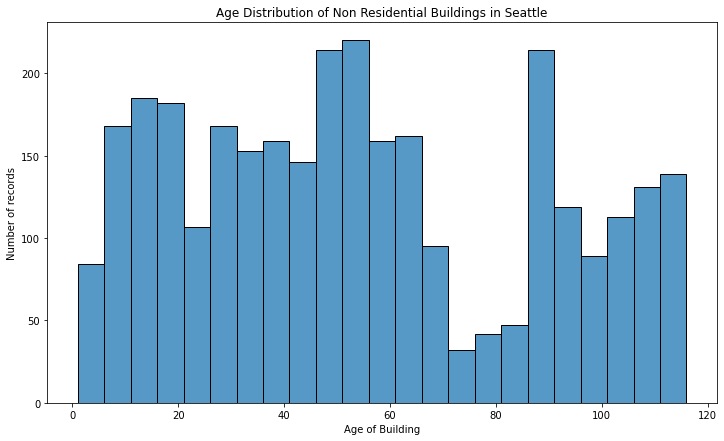

In [32]:
data_comp3 = data_comp2.assign(AgeofBuilding = data_comp2['DataYear'] - data_comp2['YearBuilt'])
data_comp3.drop('YearBuilt', axis=1, inplace=True)

fig = plt.figure(figsize=(12,7))
inter = int((data_comp3['AgeofBuilding'].max() - data_comp3['AgeofBuilding'].min())/5)
ax = sns.histplot(data=data_comp3, x='AgeofBuilding', bins=inter)
ax.set_xlabel("Age of Building")
ax.set_ylabel("Number of records")
plt.title("Age Distribution of Non Residential Buildings in Seattle")
plt.show()

In [33]:
sum_column = data_comp3["PropertyGFAParking"] + data_comp3["PropertyGFABuilding(s)"]

print("Parking + Building Ground Floor Area (GFA) is equal to Total Property GFA :", sum_column.equals(data_comp3['PropertyGFATotal']))

Parking + Building Ground Floor Area (GFA) is equal to Total Property GFA : True


Text(0, 0.5, 'PropertyGFATotal (sf)')

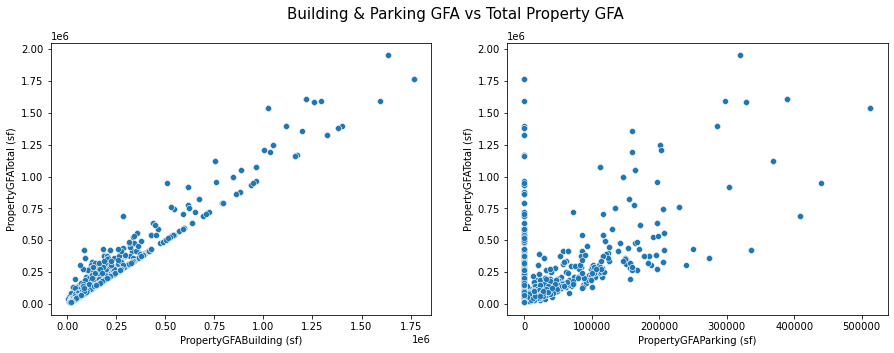

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15,5)) 
fig.suptitle("Building & Parking GFA vs Total Property GFA", fontsize=15)

sns.scatterplot(data=data_comp3, x='PropertyGFABuilding(s)', y = 'PropertyGFATotal', ax=axes[0])
axes[0].set_xlabel("PropertyGFABuilding (sf)")
axes[0].set_ylabel("PropertyGFATotal (sf)")

sns.scatterplot(data=data_comp3, x='PropertyGFAParking', y = 'PropertyGFATotal', ax=axes[1])
axes[1].set_xlabel("PropertyGFAParking (sf)")
axes[1].set_ylabel("PropertyGFATotal (sf)")

One data point seems to be an outlier with a Building GFA amlost 5 times more important than the other buildings.

In [35]:
data_comp3[data_comp3['PropertyGFABuilding(s)'] > 3*10**6]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,...,GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),Outlier,Latitude,Longitude,Address,City,State,ZipCode,AgeofBuilding


The University of Washington - Seattle Campus spread over 634 acres according to wikipedia, which represents 2.7e7 sf. Even if this value seems legitimate, this an atypical data point compared to the other buildings and we won't use it for the analysis.

In [36]:
data_comp3 = data_comp3[data_comp3['PropertyGFABuilding(s)'] < 3*10**6]


Text(0, 0.5, 'PropertyGFATotal (sf)')

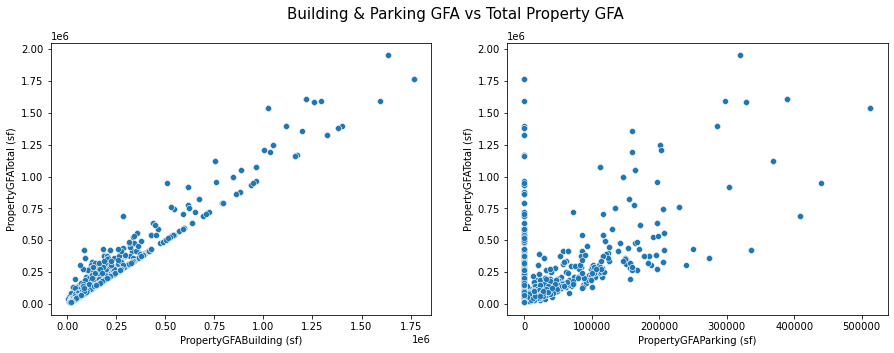

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15,5)) 
fig.suptitle("Building & Parking GFA vs Total Property GFA", fontsize=15)

sns.scatterplot(data=data_comp3, x='PropertyGFABuilding(s)', y = 'PropertyGFATotal', ax=axes[0])
axes[0].set_xlabel("PropertyGFABuilding (sf)")
axes[0].set_ylabel("PropertyGFATotal (sf)")

sns.scatterplot(data=data_comp3, x='PropertyGFAParking', y = 'PropertyGFATotal', ax=axes[1])
axes[1].set_xlabel("PropertyGFAParking (sf)")
axes[1].set_ylabel("PropertyGFATotal (sf)")

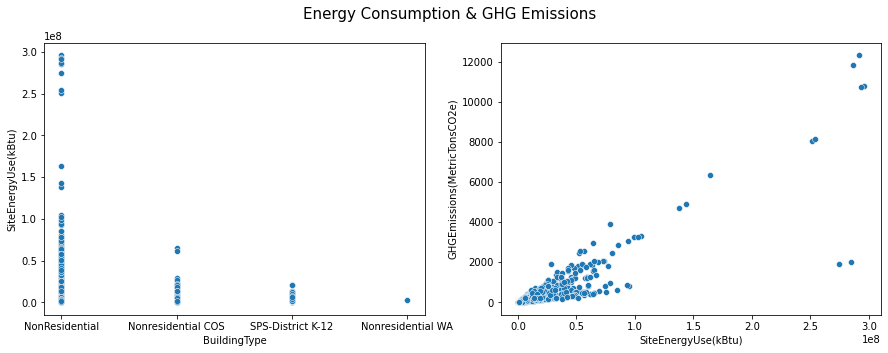

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15,5)) 
fig.suptitle("Energy Consumption & GHG Emissions", fontsize=15)

sns.scatterplot(data=data_comp3, x='BuildingType', y = 'SiteEnergyUse(kBtu)', ax=axes[0])
axes[0].set_xlabel("BuildingType")
axes[0].set_ylabel("SiteEnergyUse(kBtu)")

sns.scatterplot(data=data_comp3, x='SiteEnergyUse(kBtu)', y = 'GHGEmissions(MetricTonsCO2e)', ax=axes[1])
axes[1].set_xlabel("SiteEnergyUse(kBtu)")
axes[1].set_ylabel("GHGEmissions(MetricTonsCO2e)")
plt.show()

Few data points are still out of range compared to the main bulk of points. Applying the quantile method at 99.5% will only remove around 40 outliers over 3000 data points but the scale of the targets can be focused on the bulk of the points.

In [39]:
upperlim = data_comp3['SiteEnergyUse(kBtu)'].quantile(0.995)
lowerlim = data_comp3['SiteEnergyUse(kBtu)'].quantile(0.005)
data_comp4 = data_comp3[data_comp3['SiteEnergyUse(kBtu)']<upperlim]
data_comp5 = data_comp4[data_comp4['SiteEnergyUse(kBtu)']>lowerlim]

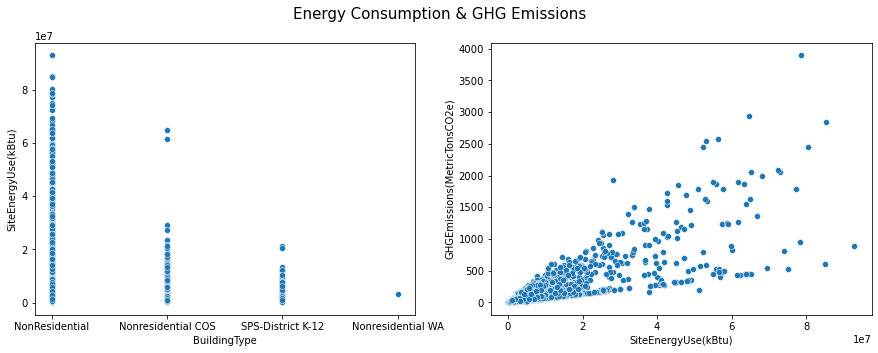

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15,5)) 
fig.suptitle("Energy Consumption & GHG Emissions", fontsize=15)

sns.scatterplot(data=data_comp5, x='BuildingType', y = 'SiteEnergyUse(kBtu)', ax=axes[0])
axes[0].set_xlabel("BuildingType")
axes[0].set_ylabel("SiteEnergyUse(kBtu)")

sns.scatterplot(data=data_comp5, x='SiteEnergyUse(kBtu)', y = 'GHGEmissions(MetricTonsCO2e)', ax=axes[1])
axes[1].set_xlabel("SiteEnergyUse(kBtu)")
axes[1].set_ylabel("GHGEmissions(MetricTonsCO2e)")
plt.show()

__Feature collinearity__

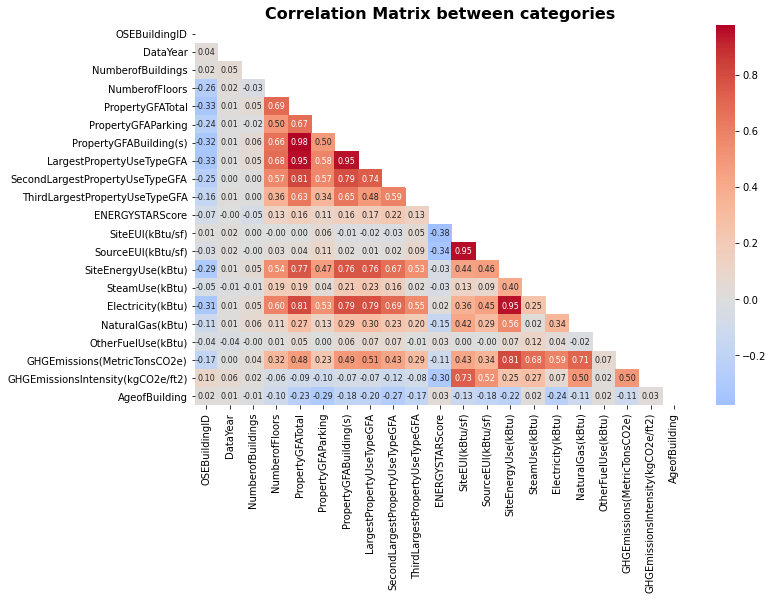

In [41]:
correlation_mat = data_comp5.corr()
plt.figure(figsize=(11,7))

mask = np.zeros_like(correlation_mat)
mask[np.triu_indices_from(mask)] = True

res = sns.heatmap(correlation_mat, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")

plt.title('Correlation Matrix between categories', fontsize = 16, weight = 'bold')
plt.show()

Through this correlation matrix, we can see that few features are very much correlated. Multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of any regression model. We might not be able to trust the p-values to identify independent variables that are statistically significant.<br>
In order to mitigate this problem, we'll need to create new features that will reduce this collinearity while dropping some others. By creating these new features, we are increasing the likelihood that one of the new variables has more predictive power over our outcome variable than the original, un-transformed variables.

__Reducing collinearity__

 Property GFA Total si strongly related to Number of Floors, Number of Buildings and any type of ground floor area. We first create 2 features describing the mean ground floor area and the mean GFA of a building.

In [42]:
data_comp5['MeanBuildingGFA'] = data_comp5['PropertyGFATotal'] / data_comp5['NumberofBuildings']
data_comp5['MeanFloorGFA'] = data_comp5['PropertyGFATotal'] / data_comp5['NumberofFloors']


Amongst all the different Property Use Type, we decided to keep only the Largest Property Use Type which is significative enough and prevent us to one hot encode to many features. On top of that we create 2 additional features which represent the percentage of GFA that a building and a parking occupy in a property.

In [43]:
data_comp5.drop(['ListOfAllPropertyUseTypes'], axis=1, inplace=True)

In [44]:
data_comp5['BuildingGFApct'] = (data_comp5['PropertyGFABuilding(s)']) / (data_comp5['PropertyGFATotal'])
data_comp5['ParkingGFApct'] = (data_comp5['PropertyGFAParking'].fillna(0)) / (data_comp5['PropertyGFATotal'])

data_comp5.drop(['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
                 'ThirdLargestPropertyUseType', 'PropertyGFAParking', 'PropertyGFABuilding(s)'],
            axis=1, inplace=True)

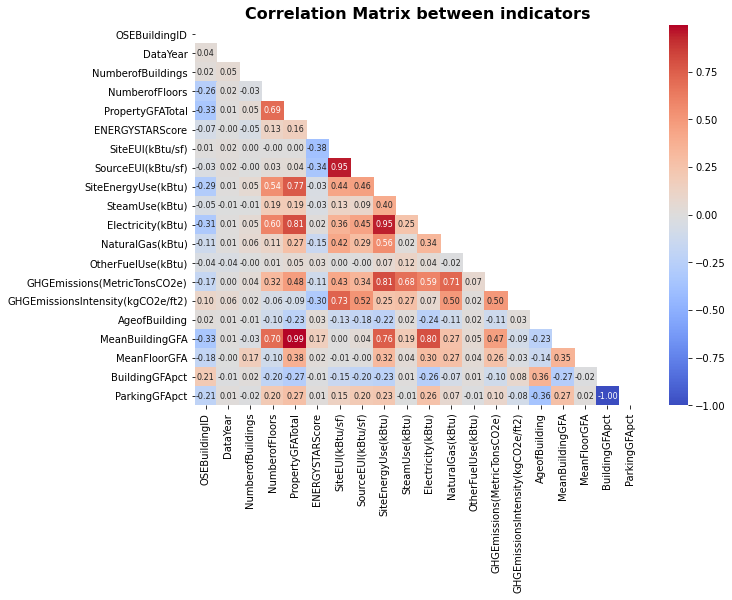

In [45]:
correlation_mat = data_comp5.corr()
plt.figure(figsize=(10,7))

mask = np.zeros_like(correlation_mat)
mask[np.triu_indices_from(mask)] = True

res = sns.heatmap(correlation_mat, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title('Correlation Matrix between indicators', fontsize = 16, weight = 'bold')
plt.show()



As seen on the above heatmap, strong correlations (in red) between the physical attributes of the buildings decreased quite a lot.

Very strong correlations still appear. Here are few equations that we can deduct:<br>
_______________________________________________________________________________________________________________

SiteEUI(kBtu/sf) = SiteEnergyUse(kBtu) / PropertyGFATotal (sf)<br>

SiteEnergyUse(kBtu) = Electricity(kBtu) + SteamUse(kBtu) + NaturalGas(kBtu) + OtherFuelUse(kBtu)<br>

The aim of this study is to determine GHG Emissions and SiteEnergyUse not knowing any measurements so we are not going to take them as parameter.<br>
There are two types of EUI:<br>
* __Site EUI__ is the amount of heat and electricity a buildings consumes as reflected in utility bills.<br>
* __Source EUI__ traces heat and electricity use back to the original raw input creating a more holistic understanding of a building's energy use. They are both related to GFA so we can drop them having previously created new variables on building and area.

In [46]:
data_const = data_comp5.drop(['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)',
                              'OtherFuelUse(kBtu)', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
                              'GHGEmissionsIntensity(kgCO2e/ft2)'], axis=1)


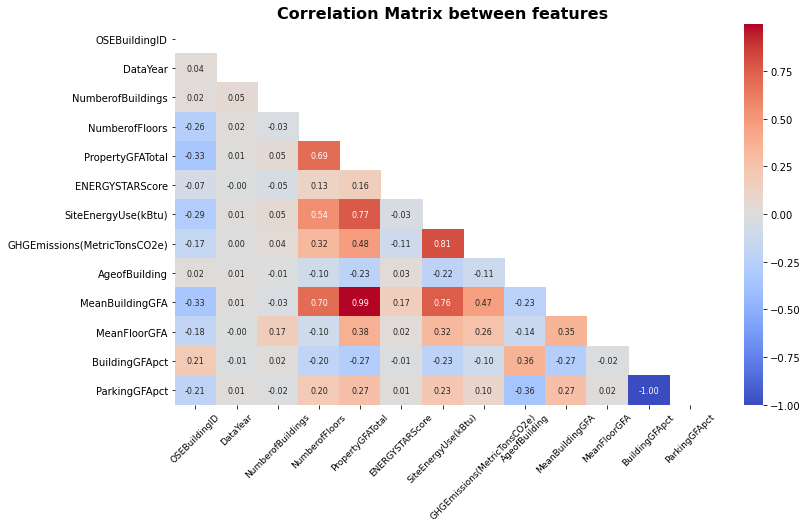

In [47]:
corr_mat = data_const.corr()
plt.figure(figsize=(12,7))

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

res = sns.heatmap(corr_mat, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 9, rotation=45)
plt.title('Correlation Matrix between features', fontsize = 16, weight = 'bold')
plt.show()


We finally created 5 new features and dropped 8 ones. Correlations between features are much less pronounced and we are going to start evaluating machine learning models from this cleaned file.

In [48]:
data_const.to_csv('data_cleaned.csv')